# Non-Negative Matrix Factorization (NMF)

Some notes I've discovered during my search for Instagram user distance.

Visualisations based on https://de.dariah.eu/tatom/topic_model_python.html#using-non-negative-matrix-factorization.


In [1]:
import psycopg2
import psycopg2.extras

import psycopg2.extensions
psycopg2.extensions.register_type(psycopg2.extensions.UNICODE)
psycopg2.extensions.register_type(psycopg2.extensions.UNICODEARRAY)

from data_cleanup import base_stopwords

conn = psycopg2.connect("dbname=twitter")
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

cur.execute("SELECT raw_text, screen_name FROM tweets")
data = cur.fetchall()
media = list(map(lambda i: i[0], data))
usernames = list(map(lambda i: i[1], data))

In [2]:
import numpy as np # a conventional alias

import sklearn.feature_extraction.text as text

vectorizer = text.CountVectorizer(input='content', strip_accents='unicode', stop_words=base_stopwords, min_df=20)

dtm = vectorizer.fit_transform(media).toarray()

vocab = np.array(vectorizer.get_feature_names())

In [3]:
from sklearn import decomposition

num_topics = 8

num_top_words = 5

clf = decomposition.NMF(n_components=num_topics, random_state=1)

doctopic = clf.fit_transform(dtm)

In [4]:
# print words associated with topics
topic_words = []

for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: react using work yeah app
Topic 1: today tomorrow yesterday experience last
Topic 2: python speakers talk year last
Topic 3: open source react github facebook
Topic 4: tech world people data time
Topic 5: talk time people work well
Topic 6: trump think people time love
Topic 7: code think people things also


In [5]:
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

In [6]:
# turn usernames into an array so we can use NumPy functions
usernames = np.asarray(usernames)

doctopic_orig = doctopic.copy()

# use method described in preprocessing section
num_groups = len(set(usernames))

doctopic_grouped = np.zeros((num_groups, num_topics))

for i, name in enumerate(sorted(set(usernames))):
    doctopic_grouped[i, :] = np.mean(doctopic[usernames == name, :], axis=0)

doctopic = doctopic_grouped

In [7]:
novels = sorted(set(usernames))

print("Top NMF topics in...")

for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    print("{}: {}".format(novels[i], top_topics_str))


Top NMF topics in...
AanandPrasad: 7 4 5
Dyzajnmarket: 5 7 3
EvNowAndForever: 0 7 3
Inventables: 7 3 5
JanHovancik: 7 4 5
JulianHi: 7 6 4
Lieke2208: 4 3 6
OndrejMirtes: 7 6 4
PortraitDaily: 1 7 6
Prague_CM: 5 1 2
Sartorialist: 5 2 1
TAtanasoska: 7 4 6
Tejazz89: 4 5 7
_developit: 7 0 3
adrianmouat: 5 7 6
aerotwist: 7 5 0
alesroubicek: 7 5 4
andy_matuschak: 7 5 6
annthurium: 5 7 2
aral: 4 7 5
ari_grant: 5 6 0
benjaminhaddad: 6 4 1
chris_emerson: 6 7 5
cincura_net: 7 6 0
codeinthehole: 7 5 4
compiledwrong: 7 4 1
cpojer: 0 5 3
dan_abramov: 0 7 4
dothewww: 0 7 3
fahad19: 0 4 3
fbOpenSource: 3 1 0
girlziplocked: 6 5 4
github: 3 7 5
glasnt: 5 7 3
hisham_hm: 5 7 6
jaffathecake: 7 5 0
jakevdp: 7 2 3
jedensvet: 4 6 5
jessitron: 7 5 4
jmtcz: 5 4 2
jorilallo: 6 0 7
kelseyhightower: 4 5 7
kentcdodds: 5 0 1
kpljaskovova: 7 4 5
leeb: 5 6 7
lenikrsova: 4 7 3
maccaw: 7 4 0
maxvoltar: 6 5 7
mrchrisadams: 6 3 7
mxstbr: 5 0 7
myusuf3: 0 7 4
naPyvo: 2 1 7
nikdo: 7 5 4
ntr23: 4 0 6
plantsimulator: 7 6 5
pyc

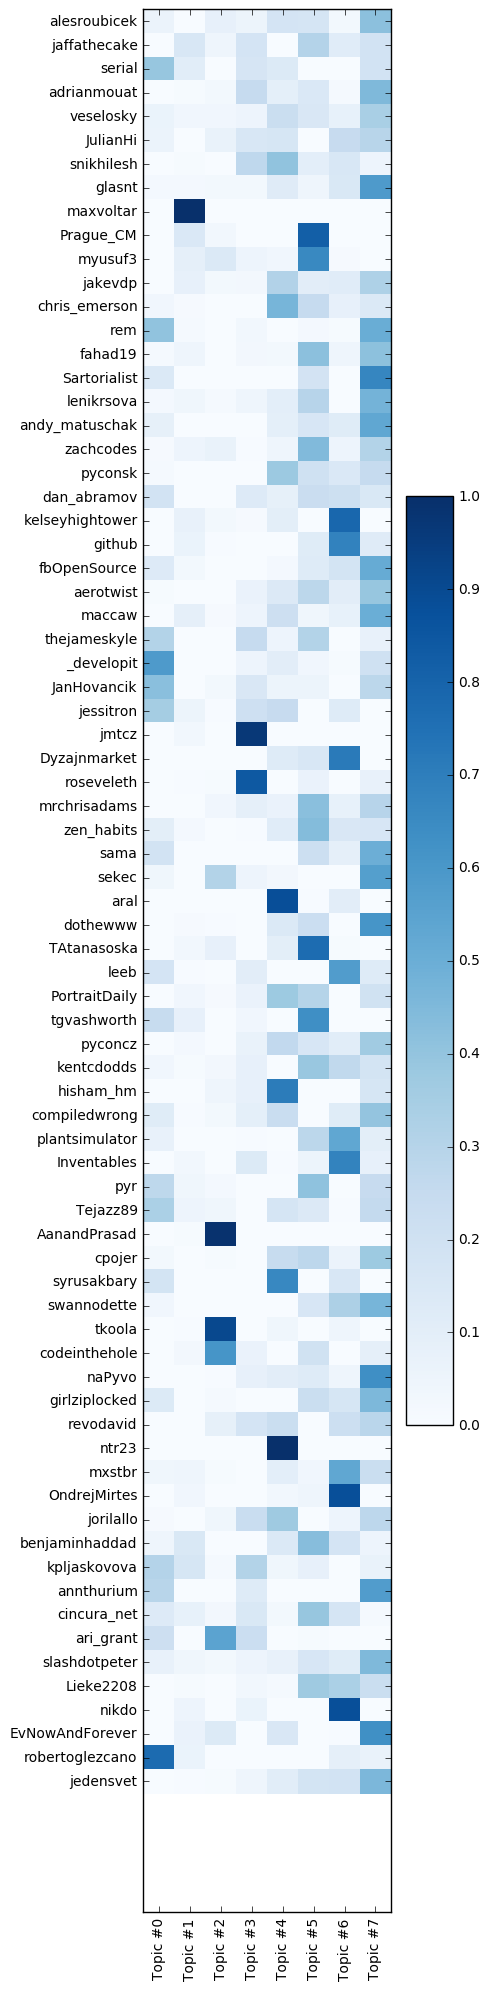

In [8]:
N, K = doctopic.shape

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 20))  # use a bigger canvas than usual

plt.pcolor(doctopic, norm=None, cmap='Blues')
 
topic_labels = ['Topic #{}'.format(k) for k in range(K)]

# put the major ticks at the middle of each cell
# the trailing semicolon ';' suppresses output
plt.yticks(np.arange(doctopic.shape[0])+0.5, usernames);

plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')

plt.tight_layout()  # fixes margins

plt.show()